## Tracking Dynamic Time Series Phenology with HLS Data

This tutorial demonstrates how to access **Harmonized Landsat Sentinel-2 (HLS) Version 2** (Ju et al. 2025) data using the `CMR-STAC` API combined with the `OpenDataCube` (ODC) framework to analyze time series of vegetation indices—specifically EVI and NDVI. `OpenDataCube` leverages STAC metadata to enable lazy loading of HLS data directly from the cloud. Using user-defined search parameters, the data query through `CMR-STAC` paired with `dask` parallelization accelerates data retrieval and offers an efficient, scalable workflow for working with large HLS datasets.

The **Normalized Difference Vegetation Index (NDVI)** and **Enhanced Vegetation Index (EVI)** are widely used proxies for monitoring vegetation growth and health. HLS data improves our ability to track vegetation phenology by providing high-resolution satellite observations every **1.6 days** (Zhou et al. 2025) at **30-meter** spatial resolution. The goal of this project is to observe time series of HLS-derived EVI and NDVI over targeted regions without the need to download the entire HLS dataset.

## Background

The HLS project produces seamless, harmonized surface reflectance products by combining data from the Operational Land Imager (OLI) aboard Landsat satellites and the Multi-Spectral Instrument (MSI) on Sentinel-2 satellites. These products undergo atmospheric correction, cloud and shadow masking, geographic co-registration, common gridding, bidirectional reflectance distribution function normalization, and spectral band adjustment.

One of the key applications of HLS data is agricultural assessment and monitoring, which is the use case highlighted in this tutorial.

HLS data is available as uncompressed Cloud Optimized GeoTIFFs (COGs) on Amazon Web Services (AWS) Simple Storage Service (S3). Leveraging cloud-native geospatial workflows allows users to efficiently retrieve and process specific areas of interest (AOIs) without downloading entire scenes or manually searching for data. This cloud-based approach reduces time-consuming data transfers and storage demands, enabling users to focus on analysis using open-source tools and to visualize and work with large-scale HLS data directly in the cloud.


## Requirements
A NASA Earthdata Login account is required to download the data used in this tutorial. <font color="blue">[Create an account here](https://urs.earthdata.nasa.gov/users/new)</font>.


## Learning Objectives
- Learn how to work with HLS Landsat (HLSL30.002) and Sentinel-2 (HLSS30.002) data products.
- Learn how to use HLS to access the temporal changes of vegetation phenology indexes.


## Data Used
**HLSS30.002** – 30 m global HLS Sentinel-2 MSI Surface Reflectance
- Derived from Sentinel-2A and 2B MSI data


**HLSL30.002** – 30 m global HLS Landsat-8 OLI Surface Reflectance
- Derived from Landsat-8 OLI data




## Tutorial Outline
<font color="blue">[1. Getting started](#1.-Getting-started)</font> 
- <font color="blue">[1.1. Python Environment and Packages](#1.1.-Python-Environment-and-Packages) </font> 
- <font color="blue">[1.2. EarthData Login](#1.2.-Earthdata-Login)</font> 
- <font color="blue">[1.3. Set up Dask Client](#1.3.-Set-up-Dask-Client)</font> 
- <font color="blue">[1.4. Configure GDAL Options and rio environment](#1.4.-Configure-GDAL-Options-and-rio-environment)</font> 

<font color="blue">[2. CMR-STAC Search](#2.-CMR-STAC-Search)</font> 
- <font color="blue">[2.1 Rename Common Bands](##2.1-Rename-Common-Bands) </font> 

<font color="blue">[3. Loading HLS data using ODC-STAC](#3.-Loading-HLS-data-using-ODC-STAC)</font> 

<font color="blue">[4. Phenology Change Detection Analysis](#4.-Phenology-Change-Detection-Analysis)</font> 

# 1. Getting started


## 1.1. Python Environment and Packages

To get started, make sure you have all the necessary Python packages installed. You can easily install them using the provided ```requirements.txt``` file. Simply open a terminal in the notebook's directory and run:


In [ ]:
pip install -r requirements.txt

This will ensure your environment has all the dependencies needed to run the notebook smoothly. If you’re using a virtual environment, activate it first before running the command.

To begin using this notebook, make sure all necessary Python packages are imported. These libraries provide functions for accessing, processing, and visualizing HLS data. Run the following cell to import the required packages. If you encounter any ```ModuleNotFoundError```, ensure the package is installed by checking your environment or referring to the ```requirements.txt``` file.

In [3]:
%matplotlib inline

import os
from datetime import datetime
import numpy as np
import pandas as pd
import geopandas as gp
from skimage import io
import matplotlib.pyplot as plt
from osgeo import gdal
import xarray as xr
import rioxarray as rxr
import hvplot.xarray
import hvplot.pandas
import earthaccess
import pystac_client
import dask.distributed
import odc.stac
import xarray as xr
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
%run -i ./tools/plotting.ipynb
%run -i ./tools/data_access.ipynb
%run -i ./tools/ultilities.ipynb

## 1.2. Earthdata Login

We will use the ```earthaccess``` package for authentication. This <font color="blue">[tool](https://github.com/nsidc/earthaccess#readme)</font> can either create a new local ```.netrc``` file to securely store your NASA Earthdata credentials or validate an existing one in your user profile. If no ```.netrc``` file is found, you’ll be prompted to enter your credentials, and a file will be created for future use.

```earthaccess``` also manages token expiration automatically. It tracks expired credentials internally and refreshes them using stored <font color="blue">[refresh_tokens](https://earthaccess.readthedocs.io/en/latest/user-reference/auth/auth/#earthaccess.auth.Auth.refresh_tokens)</font>, so users do not need to manually handle <font color="blue">[temporal AWS credentials](https://nasa-openscapes.github.io/2021-Cloud-Hackathon/tutorials/05_Data_Access_Direct_S3.html)</font> or token renewals.

In [ ]:
earthaccess.login(persist=True)

## 1.4. Configure GDAL Options and rio environment

To ensure smooth handling of geospatial data, it’s important to configure GDAL options and the ```rasterio``` (```rio```) environment properly. GDAL options control how geospatial files are read, written, and processed, such as enabling Cloud Optimized GeoTIFF (COG) support or setting cache sizes.

In [5]:
# GDAL configurations used to successfully access LP DAAC Cloud Assets via vsicurl 
gdal.SetConfigOption('GDAL_HTTP_COOKIEFILE','~/cookies.txt')
gdal.SetConfigOption('GDAL_HTTP_COOKIEJAR', '~/cookies.txt')
gdal.SetConfigOption('GDAL_DISABLE_READDIR_ON_OPEN','EMPTY_DIR')
gdal.SetConfigOption('CPL_VSIL_CURL_ALLOWED_EXTENSIONS','TIF')
gdal.SetConfigOption('GDAL_HTTP_UNSAFESSL', 'YES')
gdal.SetConfigOption('GDAL_HTTP_MAX_RETRY', '10')
gdal.SetConfigOption('GDAL_HTTP_RETRY_DELAY', '0.5')
gdal.SetConfigOption('CPL_VSIL_CURL_USE_HEAD', 'FALSE')

# 2. CMR-STAC Search

To find the HLS data for a certain purpose, there are some analysis parameters to define:

The following cell set important parameters for the analysis:

* ```lat```: The central latitude to analyse.
* ```lon```: The central longitude to analyse.
* ```buffer```: The number of square degrees to load around the central latitude and longitude. For reasonable loading times, set this as 0.1 or lower.
* ```baseline_year```: The baseline year, to use as the baseline (or starting time) of urbanisation 
* ```analysis_year```: The analysis year to analyse the change in urbanisation


In [6]:
# Define the analysis parameter for the analysis 
lat = 39.478
lon = -122.061
lat = 33.0344
lon = -115.4351
buffer_lat = 0.0075
buffer_lon = 0.015
baseline_year = 2021
analysis_year = 2021

In [7]:
# Combine central lat,lon with buffer to get area of interest
lat_range = (lat - buffer_lat, lat + buffer_lat)
lon_range = (lon - buffer_lon, lon + buffer_lon)

The next cell will display the selected area on an interactive map. Feel free to zoom in and out to get a better understanding of the area you'll be analysing. Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.


In [8]:
display_map(lon_range, lat_range)

To find HLS data, we will use the pystac_client python library to search NASA's Common Metadata Repository SpatioTemporal Asset Catalog (CMR-STAC) for HLS data.

Add the collection, datetime range, results limit, a bounding box and store these as search parameters. After defining these, conduct a stac search using the LPCLOUD STAC endpoint and return our query as a list of items.


In [ ]:
item_list = search_cmr_stac(baseline_year,analysis_year,lat_range,lon_range)

## 2.1. Rename Common Bands
It is important to note that HLS data comes in two tile types—**S30** (Sentinel-2-based) and **L30** (Landsat-based)—each with different band naming conventions. Table 1 shows the spectral band nomenclature for both products. To ensure consistency in analysis, it is recommended to standardize band names across the two products. For example, **HLSL30 B5** and **HLSS30 B8A** can both be renamed to **NIR Narrow** to reflect their equivalent spectral range.

**Table 1**: HLS spectral bands nomenclature
|HLSL30 Band Name|HLSS30 Band Name|Band|Wave length (micrometers)|
|:---|:---:|---:|---:|
|B02|B02|Blue|0.45 – 0.51|
|B03|B03|Green|0.53 – 0.59|
|B04|B04|Red|0.64 – 0.67|
|B05|B8A|NIR|0.85 – 0.88|
|B06|B11|SWIR_1|1.57 – 1.65|
|B07|B12|SWIR_2|2.11 – 2.29|

Source: <font color="blue">[HLS User Guide V2](https://lpdaac.usgs.gov/documents/1698/HLS_User_Guide_V2.pdf)</font>

In [10]:
# Rename HLSS B11 and HLSL B06 to common band name SWIR1
item_list_rename = rename_common_bands(item_list)

# 3. Loading HLS data using ODC-STAC

Now that we have retrieved a list of HLS items from CMR-STAC, we can use the `odc.stac.stac_load` function to load the data efficiently as a Dask-backed parallel operation. Before loading, we need to define a few key parameters:

- `crs`: The desired coordinate reference system (e.g., `'utm'`)  
- `spatial_res`: The target spatial resolution (e.g., `30` for HLS data)  
- `bands`: A list of specific spectral bands to load  

> **Note:** Loading the data may take a few minutes depending on the number of granules and system performance.


In [11]:
bbox = [min(lon_range), min(lat_range), max(lon_range), max(lat_range)]
bands = ['NIR','Blue','Green','Red','Fmask']
ds = load_odc_stac('utm',bands,30,item_list_rename,bbox)

In [12]:
# return a dictonary with time index and sat_id
key_list = ds.time.values
value_list = ['_'.join(i.id.split('.')[:2]) for i in item_list_rename]
dict_sat_id = {key: value for key, value in zip(key_list, value_list)}

# 4. Phenology Change Detection Analysis

## 4.1. Scale the data
The ```scale_factor``` information in some of the HLSL30 granules are found in the file metadata, but missing from the Band metadata, meaning this isn't applied automatically. Manually scale each of the data arrays by the scale factor.



In [13]:
ds_mask_scaled = scale_hls_data(ds,bands)

## 4.2. Load the data 
This is the most time-consuming step of the workflow. Up to this point, we have only **lazily loaded** the data using Dask, meaning no actual data has been read—only metadata and structure are available. For example, inspecting a variable like `SWIR_1` shows it as a `dask.array`, but the underlying data has not yet been retrieved.

To perform any analysis, we need to trigger data loading using the `.load()` method, which initiates the actual data transfer from the S3 server. 

> **Note:** Retrieving HLS data via remote access (`vsicurl`) has known issues. See this related discussion on the <font color="blue">[Earthdata Forum](https://forum.earthdata.nasa.gov/viewtopic.php?t=5207&sid=15f046472f28eb9c21604f2cf8b87f79&start=10)</font>.

To handle these issues, we implement a loop that calls `.load()` for each dataset. If an error occurs due to GDAL or Rasterio configuration, the environment is reset and the loading process is retried.

When you call `.load()` on a Dask-backed Xarray object, many small read tasks are scheduled across chunks. However, by that point, you're no longer inside the `rasterio.Env()` context that was active during file opening. To ensure GDAL and Rasterio settings are correctly applied during these reads, you have three main options:

1. Monkey-patch Xarray’s `.load()` to wrap each read in a `rasterio.Env()` context  
2. Monkey-patch `rasterio.open()` itself  
3. Pre-configure each Dask worker with the appropriate GDAL environment settings

In this notebook, we use a helper function `configure_gdal_rasterio_dask()` to apply the necessary GDAL and Rasterio settings across the Dask environment before triggering the data load.

In [ ]:
configure_gdal_rasterio_dask()

When using Dask, initializing a ```Client()``` provides a link to a local dashboard (usually at ```http://localhost:8787```) where you can monitor the progress of your tasks in real time. The dashboard offers detailed insights into resource usage, task execution status, memory consumption, and worker performance—making it a valuable tool for optimizing and debugging your parallel data processing workflows.

In [ ]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(processes=False, local_directory='/tmp') 

client = Client(cluster)
client

After modifying the GDAL configuration, we can apply the ```.load()``` function to load data from the remote server into memory in parallel.

In [17]:
import time
start = time.time()
ds_mask_scaled_sel = load_data_into_memory(ds_mask_scaled)
end = time.time()
print(f"⏱️ Computation time: {end - start:.2f} seconds")

⏱️ Computation time: 76.69 seconds


Let look at some snapshots of the HLS data over the year across different seasons. 

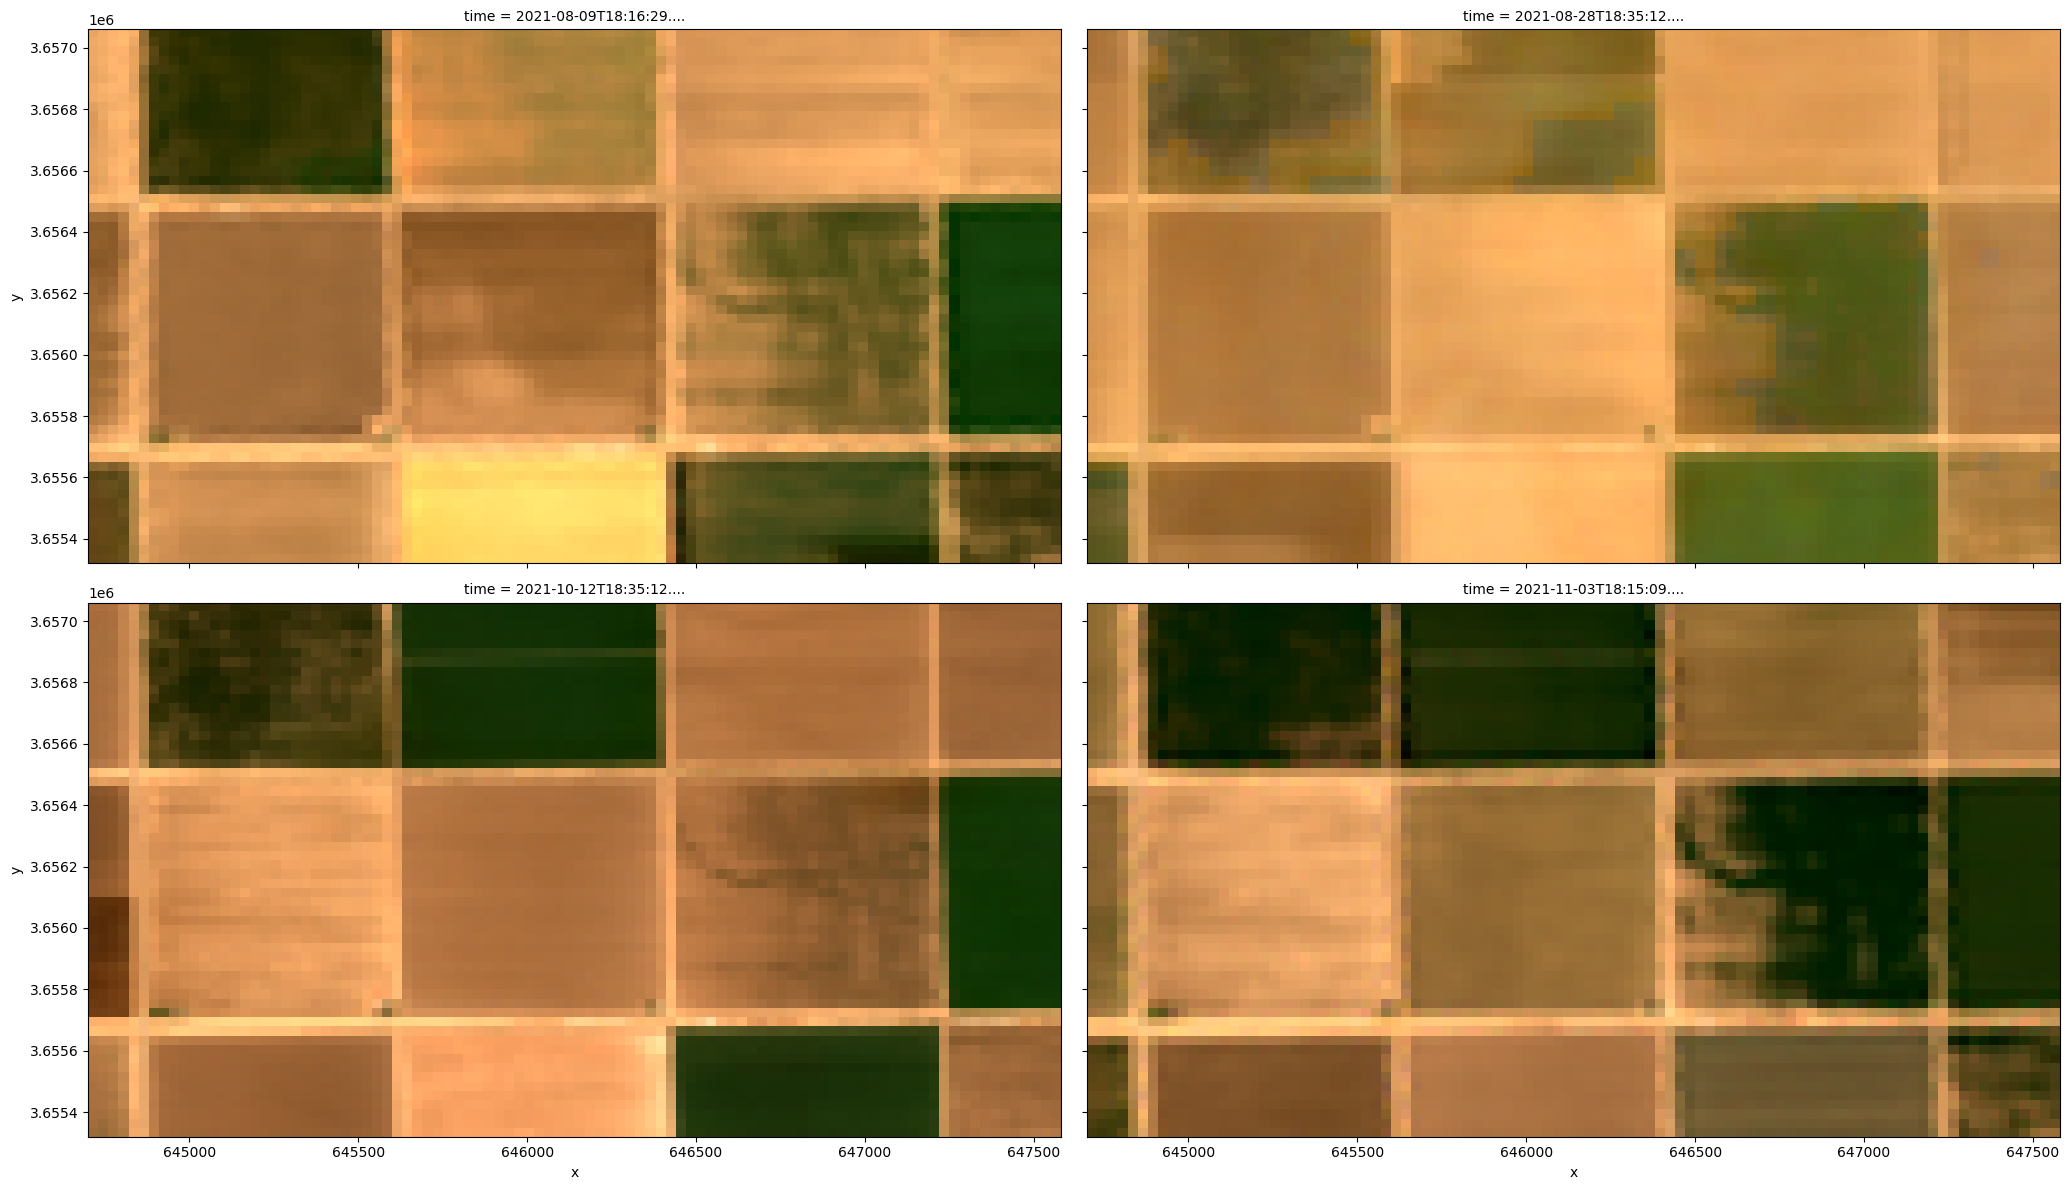

In [19]:
rgb(ds_mask_scaled_sel,
    bands=['Red','Green','Blue'],
    index=[55,60,72,78],
    col_wrap=2)

## 4.3. EVI Estimation

Now we can build an Enhanced Vegetation Index (EVI) dataset using the EVI formula:

$\text{EVI} = G \cdot \frac{\text{NIR} - \text{Red}}{\text{NIR} + C_1 \cdot \text{Red} - C_2 \cdot \text{Blue} + L}$

- NIR: Near-Infrared reflectance.
- Red: Reflectance in the red band.
- Blue: Reflectance in the blue band, used primarily to correct for aerosol influences.
- G: Gain factor (often set to 2.5) that scales the index.
- C₁: Coefficient for the aerosol resistance term using the red band (commonly 6).
- C₂: Coefficient for the aerosol resistance term using the blue band (commonly 7.5).
- L: Canopy background adjustment, which helps to minimize soil brightness influences (commonly 1).

We will use the typical values adopted for the MODIS algorithm for G, C1, C2 and L. The output values will range from -1 to 1 and indicate strength of vegetation signal, which correlates with biomass.



In [20]:
# Calculate EVI
evi_ds = 2.5 * ((ds_mask_scaled_sel.NIR - ds_mask_scaled_sel.Red) / 
                (ds_mask_scaled_sel.NIR + 6.0 * ds_mask_scaled_sel.Red - 
                 7.5 * ds_mask_scaled_sel.Blue + 1.0))
evi_ds = evi_ds.compute()

Plot to demonstrate the images of EVI over time 

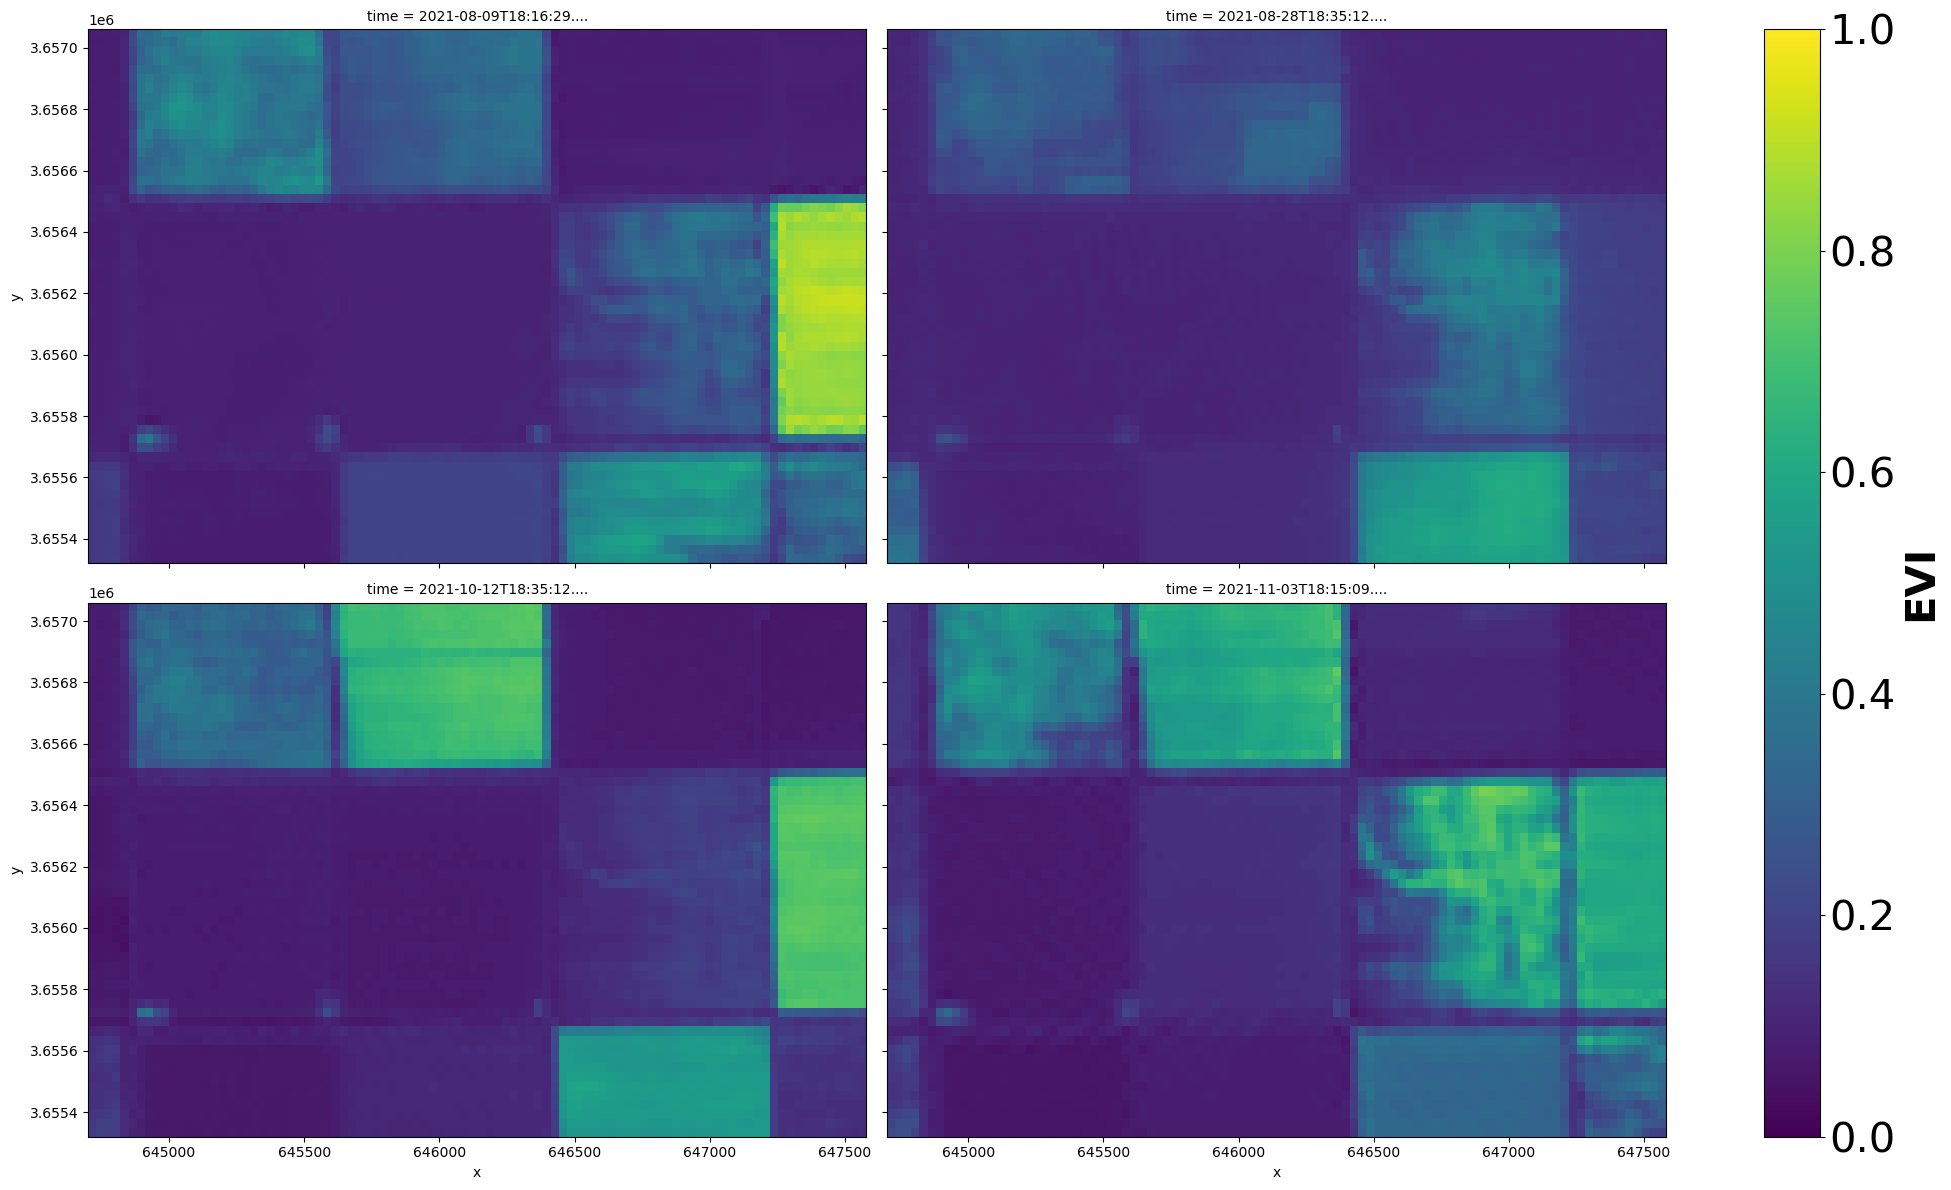

In [33]:
img = single_band(evi_ds,vmin=0,vmax=1,index=[55,60,72,78],col_wrap=2,cmap='viridis',label='EVI')

## 4.4. Quality Filtering
For <font color="blue">[HLS V2](https://lpdaac.usgs.gov/documents/1698/HLS_User_Guide_V2.pdf)</font> products, all quality information is encoded in the **Fmask** layer. This layer contains bitwise flags representing various quality attributes for each pixel in the scene. The bits are ordered from bit 7 (most significant) to bit 0 (least significant) and correspond to the following quality descriptions:

| Bit Number | Mask Name              | Bit Values     | Description                  |
|------------|------------------------|----------------|------------------------------|
| 7–6        | Aerosol Level          | 11, 10, 01, 00 | High, Medium, Low, Clear     |
| 5          | Water                  | 1, 0           | Yes, No                      |
| 4          | Snow/Ice               | 1, 0           | Yes, No                      |
| 3          | Cloud Shadow           | 1, 0           | Yes, No                      |
| 2          | Cloud/Shadow Adjacent  | 1, 0           | Yes, No                      |
| 1          | Cloud                  | 1, 0           | Yes, No                      |
| 0          | Cirrus                 | Reserved       | N/A                          |

For example, the 8-bit integer value **224** in binary is `11100000`. This indicates **high aerosol levels** (bits 7–6 = `11`) and the presence of **water** (bit 5 = `1`) at that pixel.


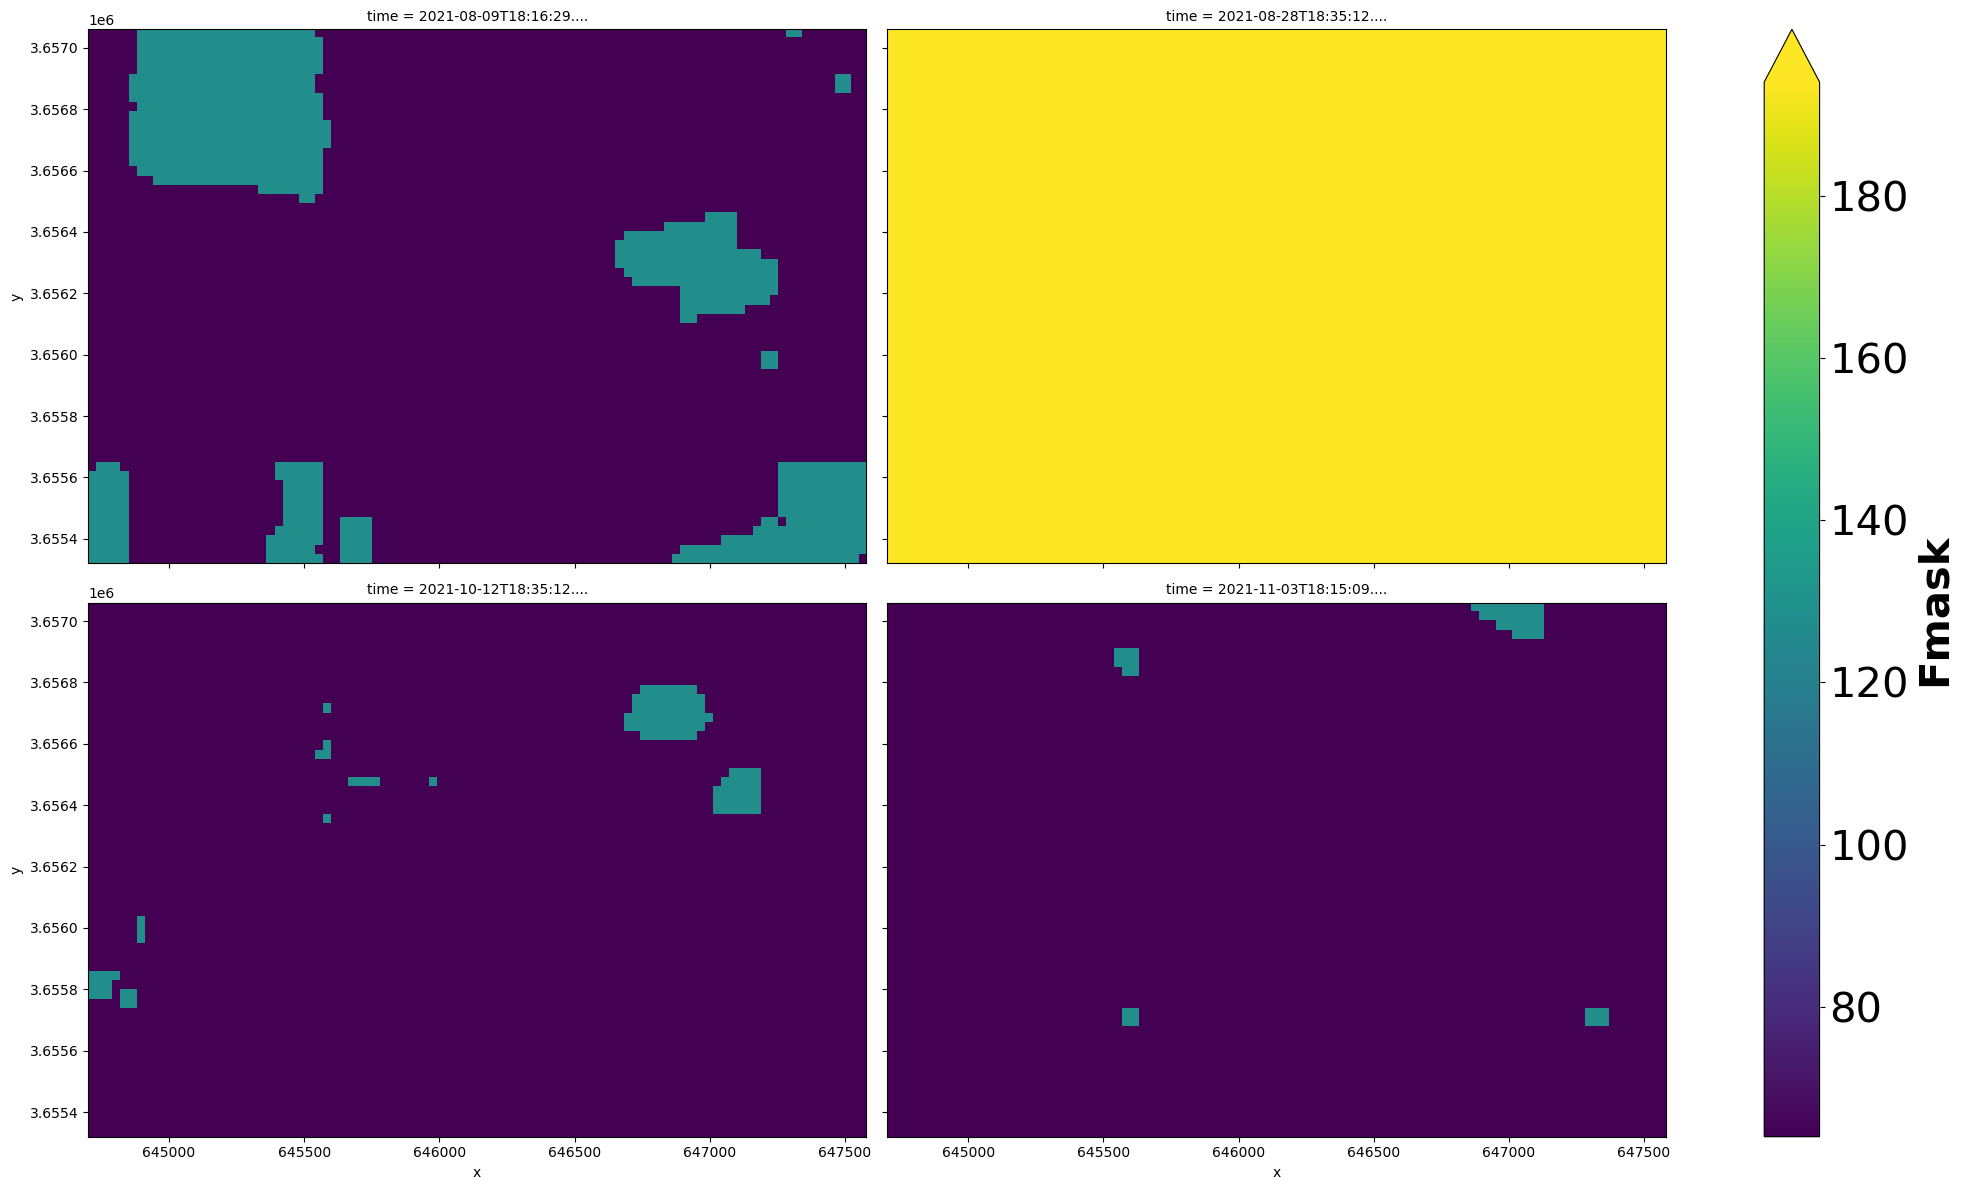

In [34]:
single_band(ds_mask_scaled_sel['Fmask'],
            index=[55,60,72,78],
            col_wrap=2,
            label='Fmask')

We can selectively mask out pixels based on specific ```Fmask``` bit flags that represent unwanted conditions. In this case, we will exclude pixels identified as:

- Cloud (bit 1)
- Cloud/Shadow Adjacent (bit 2)
- Cloud Shadow (bit 3)
- Snow/Ice (bit 4)
- Water (bit 5)

We will ignore aerosol levels (bits 6–7) in this analysis.




In [ ]:
bit_nums = [1,2,3,4,5]

Next, apply the ```create_quality_mask``` function to build the mask based on the selected bits. Then, use this mask to filter the cropped EVI image:

In [35]:
mask_layer = np.stack([create_quality_mask(ds_mask_scaled_sel['Fmask'].sel(time=ds_mask_scaled_sel.time[i]), bit_nums) 
              for i in range(len(ds_mask_scaled_sel.time))])
evi_ds_masked = evi_ds.where(~mask_layer)
mask_array_ds = evi_ds.copy()
mask_array_ds.data = mask_layer
mask_array_ds_binary = mask_array_ds.copy()
mask_array_ds_binary = mask_array_ds_binary.astype(int)

Plot the cloud-mask layer to visualize which pixels are affected by clouds. 

- **Black** areas indicate clear-sky pixels (not masked).
- **White** areas represent cloudy or otherwise masked pixels.


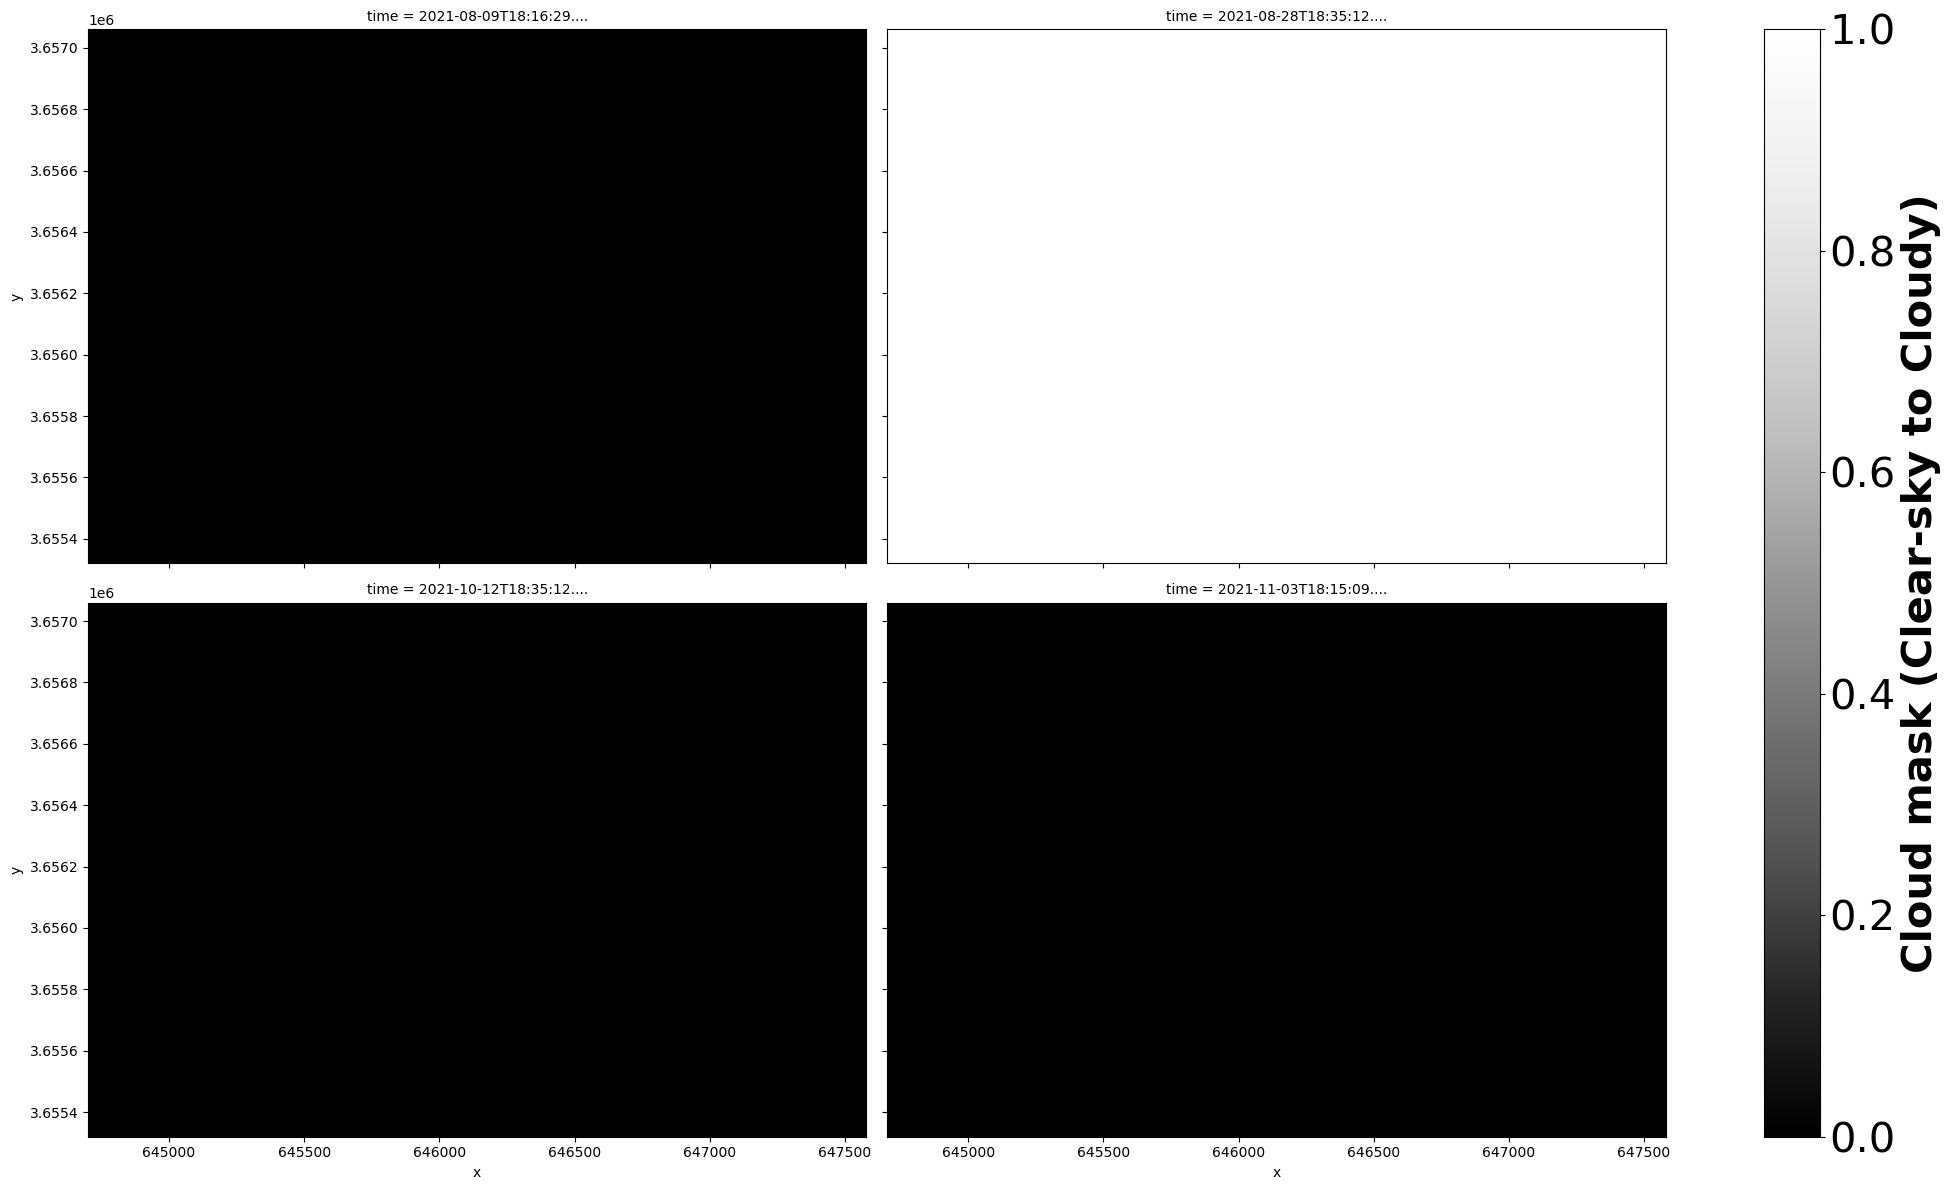

In [36]:
single_band(mask_array_ds_binary,
            index=[55,60,72,78],col_wrap=2,cmap='Greys_r',interpolation='nearest',
            label='Cloud mask (Clear-sky to Cloudy)')

Double-check the EVI output to ensure that cloudy pixels have been successfully masked out from the analysis.

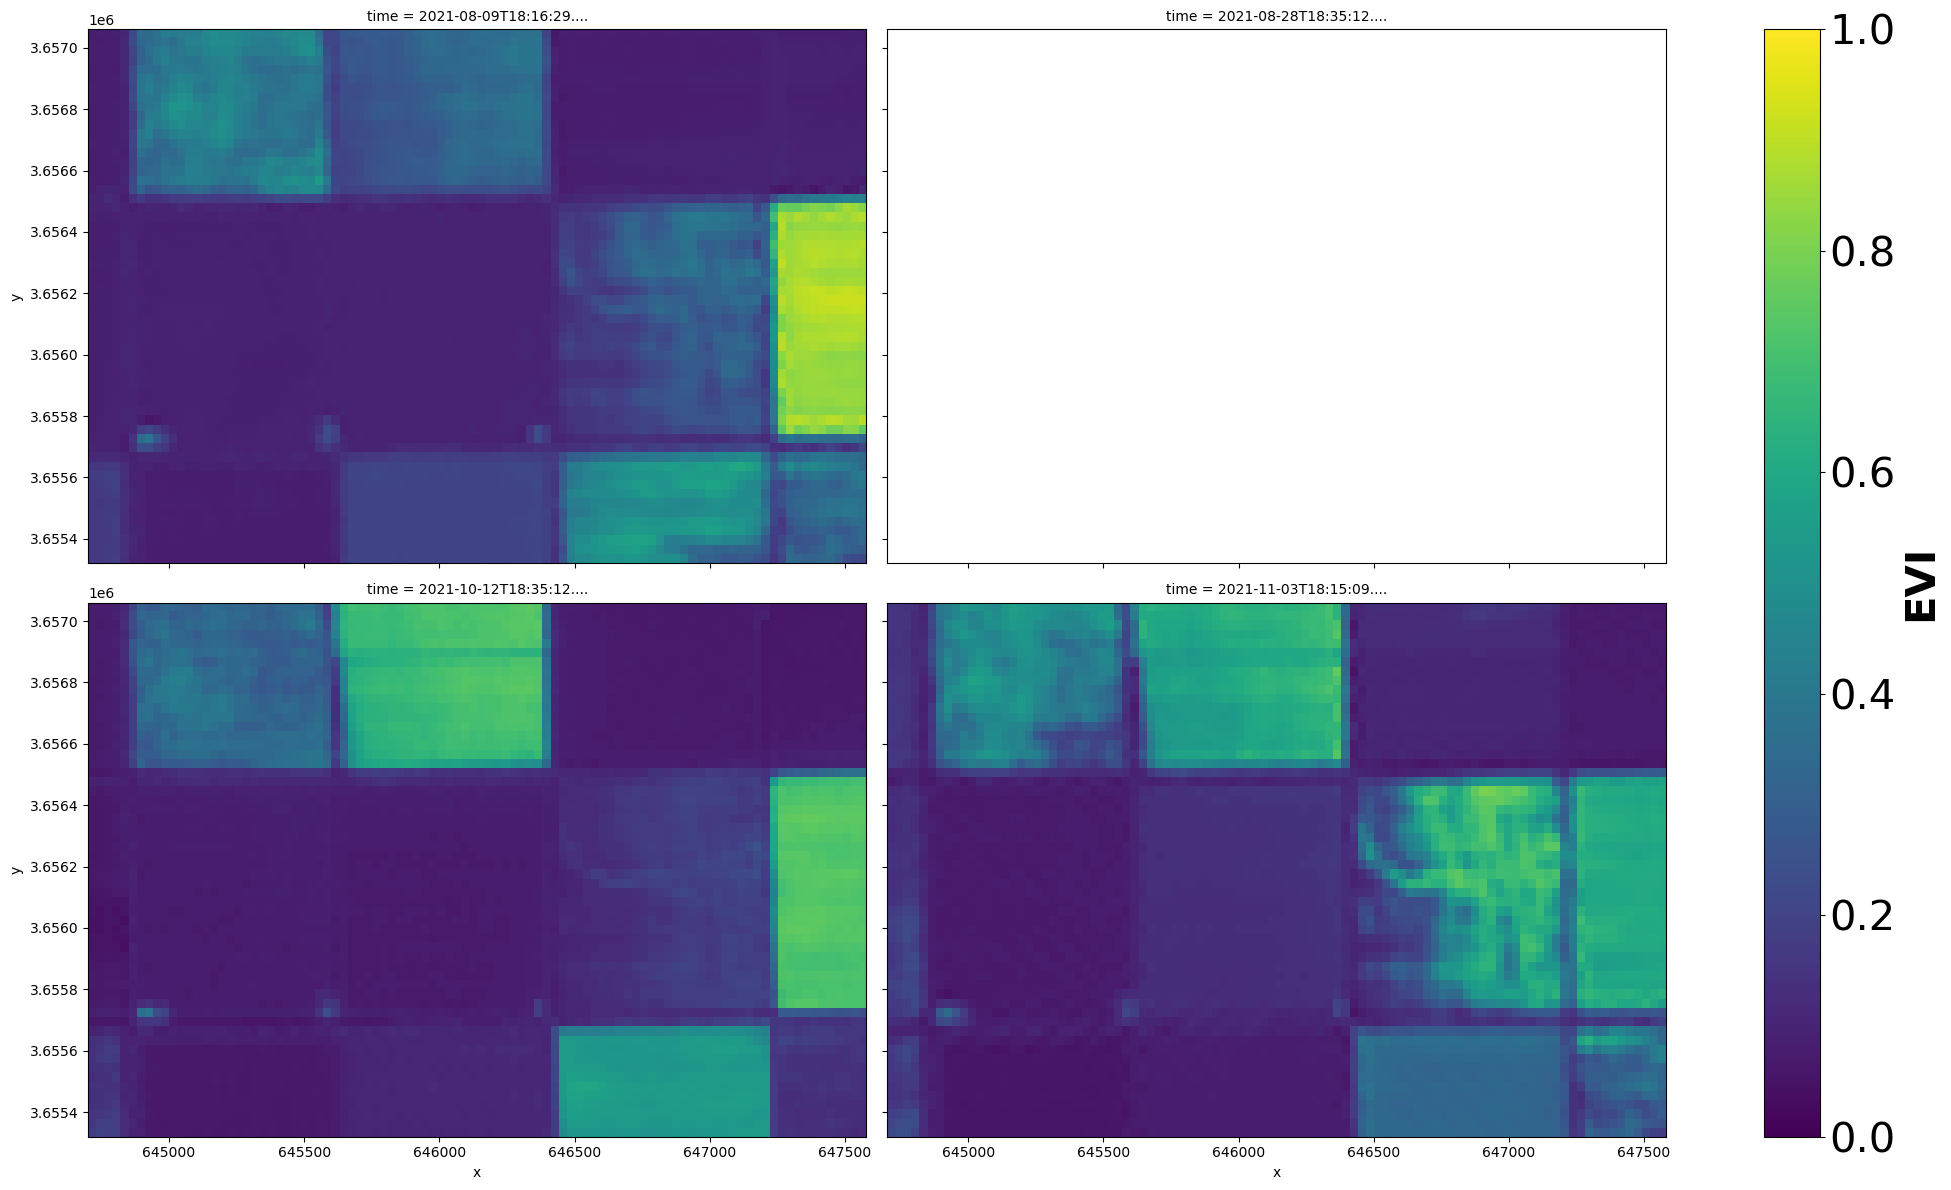

In [32]:
single_band(evi_ds_masked,vmin=0,vmax=1,
            index=[55,60,72,78],col_wrap=2,label='EVI')

As a result, the EVI images have been sucessfully processed using Fmask layer to eliminate cloudy pixels.

## 4.5. Plot the time series of vegetation index

To understand how vegetation health changes throughout the year(s), we can plot a zonal time series over the region of interest.  
It is also useful to annotate the time series with the specific dataset (Landsat or Sentinel-2) used for each observation.  
This helps illustrate the high temporal resolution and complementary coverage provided by the HLS dataset.

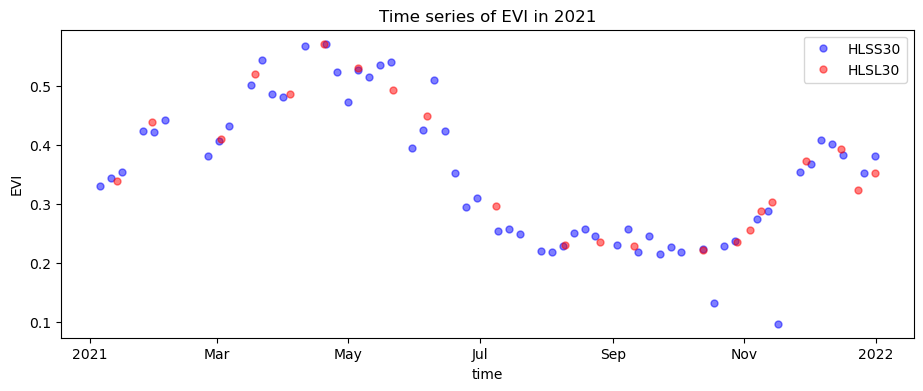

In [38]:
fig, ax = plt.subplots(figsize=(11,4))
time_S30 = [key for key, val in dict_sat_id.items() if val == 'HLS_S30']
time_L30 = [key for key, val in dict_sat_id.items() if val == 'HLS_L30']
evi_ds_masked.mean(['x', 'y']).sel(time=time_S30).plot.line('bo',ax=ax,label='HLSS30',markersize=5,alpha=0.5)
evi_ds_masked.mean(['x', 'y']).sel(time=time_L30).plot.line('ro',ax=ax,label='HLSL30',markersize=5,alpha=0.5)
plt.title('Time series of EVI in 2021')
plt.ylabel('EVI')
plt.legend()

### **Conclusion**
This tutorial demonstrated how to access and analyze time series of vegetation indices (NDVI and EVI) using Harmonized Landsat and Sentinel-2 (HLS) data in a cloud-native environment. By leveraging tools such as `CMR-STAC`, `OpenDataCube`, and `dask`, users can efficiently retrieve and process high-resolution satellite data without downloading full datasets. Through cloud masking, compositing, and temporal analysis, we explored how vegetation phenology can be monitored at fine spatial and temporal scales. This approach enables researchers and practitioners to track seasonal and interannual vegetation changes, supporting applications in agriculture, ecosystem monitoring, and land management.

### **Acknowledgements**  
The Harmonized Landsat Sentinel-2 (HLS) solution is funded by NASA and was developed to address data needs identified by the U.S. Federal Government through the Satellite Needs Working Group (SNWG) biennial survey.



### **Contact Information**  
- **Author**: Trang Vo  
- **Contributors**: Madhu Sridhar, Chuck Daniels, Chris Holden, Sean Harkins  
- **Email**: tv0015@uah.edu  
- **Organization**: NASA MSFC IMPACT Project – HLS Production Team  
- **Last Modified**: July 3, 2025  



### **References**  
- <font color="blue">[HLS Product Information](https://www.earthdata.nasa.gov/data/projects/hls)</font>
- <font color="blue">[Getting Started with Cloud-Native HLS Data in Python](https://lpdaac.usgs.gov/resources/e-learning/getting-started-cloud-native-hls-data-python/)</font>
- <font color="blue">[Building an HLS-based EVI Time Series with ODC STAC](https://github.com/nasa/HLS-Data-Resources/blob/main/python/tutorials/EVI_timeseries_with_odc_stac.ipynb)</font>
- <font color="blue">[The Harmonized Landsat and Sentinel-2 version 2.0 surface reflectance dataset](https://www.sciencedirect.com/science/article/pii/S0034425725001270)</font>
- <font color="blue">[Toward Seamless Global 30-m Terrestrial Monitoring: Evaluating 2022 Cloud Free Coverage of Harmonized Landsat and Sentinel-2 (HLS) V2.0](https://ieeexplore.ieee.org/abstract/document/10852289)</font>

